In [1]:

import pandas as pd
import glob
import os
import ast

file = "abla-all.csv"

og_df = pd.read_csv(file)
df = og_df
# trim leading/trailing spaces in all string cells
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# rename the first column (index 0) to "id"
# df.rename(columns={df.columns[0]: "id"}, inplace=True)
# df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
# df.rename(columns={'num_run.1':'num_run'},inplace=True)
# df.drop(columns=['num_run'],inplace=True)
df['model'].unique()
# df.head(5)



FileNotFoundError: [Errno 2] No such file or directory: 'abla-all.csv'

In [ ]:
import pandas as pd
import pprint
import numpy as np

# Calculate success rate for each model-processor combination
pivot_data = df.groupby(['model', 'processor', 'status']).size().unstack(fill_value=0)

# Calculate success rate
if 'success' not in pivot_data.columns:
    pivot_data['success'] = 0
if 'failure' not in pivot_data.columns:
    pivot_data['failure'] = 0

# Create dictionary with success rate information
success_rate_dict = {}
for (model, processor), row in pivot_data.iterrows():
    success_count = row['success']
    failure_count = row['failure']
    total = success_count + failure_count
    rate = success_count / total if total > 0 else 0.0
    
    success_rate_dict[(model, processor)] = {
        'success_count': int(success_count),
        'failure_count': int(failure_count),
        'total': int(total),
        'success_rate': float(rate)
    }

pprint.pprint(success_rate_dict)


{('codestral', 'dp'): {'failure_count': 19,
                       'success_count': 11,
                       'success_rate': 0.36666666666666664,
                       'total': 30},
 ('codestral', 'mc'): {'failure_count': 14,
                       'success_count': 16,
                       'success_rate': 0.5333333333333333,
                       'total': 30},
 ('codestral', 'sg'): {'failure_count': 30,
                       'success_count': 0,
                       'success_rate': 0.0,
                       'total': 30},
 ('codestral-p', 'dp'): {'failure_count': 12,
                         'success_count': 18,
                         'success_rate': 0.6,
                         'total': 30},
 ('codestral-p', 'mc'): {'failure_count': 6,
                         'success_count': 24,
                         'success_rate': 0.8,
                         'total': 30},
 ('codestral-p', 'sg'): {'failure_count': 29,
                         'success_count': 1,
                   

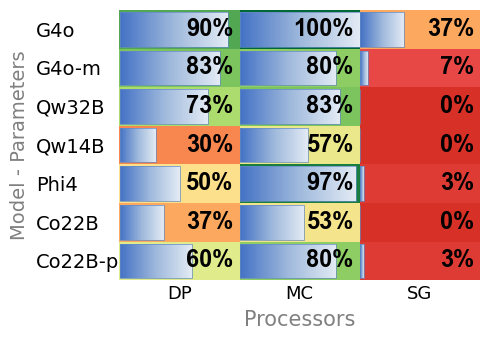

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Model name mapping
model_mapping = {
 
     'q32-ab1': 'Qw32B-ab1',  
     'q32-ab2': 'Qw32B-ab2',  
    'phi4-ab1': 'Phi4-ab1',  
    'phi4-ab2': 'Phi4-ab2',  
}

# Convert dictionary to DataFrame and pivot
heatmap_data = pd.DataFrame([
    {
        'model': model_mapping.get(model, model),
        'processor': processor,
        'success_rate': data['success_rate'] * 100
    }
    for (model, processor), data in success_rate_dict.items()
]).pivot(index='model', columns='processor', values='success_rate')

# Reorder columns and rows
heatmap_data = heatmap_data.reindex(columns=['sg', 'psg', 'tpusg'], index=list(model_mapping.values()))

# Create figure with matching size
fig, ax = plt.subplots(figsize=(5, 3.5))

# Create colormap matching the image (more pastel/muted colors)
# cmap = LinearSegmentedColormap.from_list('custom', 
#                                          ['#DC3545', '#E74C3C', '#FDCD73', '#F1C40F', 
#                                           '#CDDD81', '#AED581', '#66BB6A', '#2E7D32'], 
#                                          N=256)

cmap = LinearSegmentedColormap.from_list('custom', 
                                         [ '#D73027', '#F65D5F','#F46D43', '#FDAE61', 
                                          '#FEE08B', '#D9EF8B', '#A6D96A', '#68BA59', '#006837'], 
                                         N=256)

# Create blue gradient colormap (for progress bar)
blue_gradient = LinearSegmentedColormap.from_list('blue_gradient',
                                                 ['#4472C4', '#9FB9DC', '#E3EBF4'],
                                                   N=256)

# Set up the table structure
ax.set_xlim(0, len(heatmap_data.columns))
ax.set_ylim(0, len(heatmap_data.index))
ax.invert_yaxis()

# Progress bar height ratio
bar_height_ratio = 0.9

# Draw cells with progress bars
for i, model in enumerate(heatmap_data.index):
    for j, processor in enumerate(heatmap_data.columns):
        value = heatmap_data.loc[model, processor]
        
        if pd.notna(value):
            # Get color from colormap for background
            bg_color = cmap(value / 100)
            
            # Draw background (gradient color based on value)
            bg_rect = mpatches.Rectangle((j, i), 1, 1, 
                                        facecolor=bg_color, 
                                        edgecolor='white', 
                                        linewidth=0)
            ax.add_patch(bg_rect)
            
            # Calculate centered position
            bar_height = bar_height_ratio
            y_offset = (1 - bar_height) / 2 
            x_offset=0.005
            bar_width = value / 100
            
            # Create gradient bar using multiple thin rectangles
            n_segments = 100
            for seg in range(n_segments):
                seg_width = bar_width / n_segments
                seg_x = j + seg * seg_width
                
                # Calculate gradient position (0 to 1 across the bar)
                gradient_pos = seg / n_segments
                seg_color = blue_gradient(gradient_pos)
                
                seg_rect = mpatches.Rectangle((seg_x+x_offset, i + y_offset), seg_width, bar_height,
                                             facecolor=seg_color,
                                             edgecolor='none',
                                             linewidth=0)
                ax.add_patch(seg_rect)
            
            # Add white border around the progress bar
            bar_border = mpatches.Rectangle((j+x_offset, i + y_offset), bar_width, bar_height,
                                           facecolor='none',
                                           edgecolor='#638AC3',
                                           linewidth=0.5)
            ax.add_patch(bar_border)
            
            # Add text (always black)
            ax.text(j+0.95 , i + 0.5, f'{value:.0f}%', 
                   ha='right', va='center', 
                   fontsize=17, weight='bold', color='black', fontname='Arial')

# Set ticks and labels
ax.set_xticks([i + 0.5 for i in range(len(heatmap_data.columns))])
ax.set_yticks([i + 0.5 for i in range(len(heatmap_data.index))])
ax.set_xticklabels(heatmap_data.columns.str.upper(), fontsize=13, weight='regular')
ax.set_yticklabels(heatmap_data.index, fontsize=14, ha='left')

# Remove ticks
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='y', pad=60)

# Labels
ax.set_xlabel('Processors', fontsize=15, weight='regular', labelpad=5,color='gray')
ax.set_ylabel('Model - Parameters', fontsize=14, weight='regular', labelpad=5,color='gray'
              )

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig('success_rate_progress_bars.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd

# Load and clean dataset (assuming 'file' is defined)
# df = pd.read_csv(file)
# df.columns = df.columns.str.strip()
# df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Filter for relevant models
target_models = ['gpt-4o', 'gpt-4o-mini']
filtered_data = df[df['model'].isin(target_models)].copy()

# Split into Pass/Fail
df_pass = filtered_data[filtered_data['status'] == 'success']
df_fail = filtered_data[filtered_data['status'] != 'success']

# --- Helper Functions ---

def calculate_stats(data, metric):
    """Aggregates count, mean, and sum for a given metric."""
    if data.empty:
        return pd.DataFrame(columns=['model', 'processor', 'count', 'mean', 'sum'])
    return data.groupby(['model', 'processor'])[metric].agg(['count', 'mean', 'sum']).reset_index()

def get_mean_value(stats_df, model, processor):
    """Safely retrieves the mean value; returns 0 if not found."""
    row = stats_df[(stats_df['model'] == model) & (stats_df['processor'] == processor)]
    return row['mean'].values[0] if not row.empty else 0.0

def build_model_dict(model_name, df_pass, df_fail):
    """Constructs the dictionary for a specific model."""
    
    # Calculate aggregations for this specific model
    pass_cost = calculate_stats(df_pass, 'total_cost')
    fail_cost = calculate_stats(df_fail, 'total_cost')
    pass_lat = calculate_stats(df_pass, 'latency')
    fail_lat = calculate_stats(df_fail, 'latency')

    return {
        "latency": {
            "dp": get_mean_value(pass_lat, model_name, 'dp'),
            "mc": get_mean_value(pass_lat, model_name, 'mc'),
            "sg": get_mean_value(pass_lat, model_name, 'sg'),
            # Sum of means for the current model in the PASS dataset
            "total": pass_lat[pass_lat['model'] == model_name]['mean'].sum(),
            # Sum of means for the current model in the FAIL dataset
            "total_x": fail_lat[fail_lat['model'] == model_name]['mean'].sum()
        },
        "cost": {
            "dp": get_mean_value(pass_cost, model_name, 'dp'),
            "mc": get_mean_value(pass_cost, model_name, 'mc'),
            "sg": get_mean_value(pass_cost, model_name, 'sg'),
            "total": pass_cost[pass_cost['model'] == model_name]['mean'].sum(),
            "total_x": fail_cost[fail_cost['model'] == model_name]['mean'].sum()
        }
    }

# --- Generate Dictionaries ---

# 1. Original gpt-4o dictionary
g4o = build_model_dict('gpt-4o', df_pass, df_fail)
# 2. New gpt-4o-mini dictionary
g4o_mini = build_model_dict('gpt-4o-mini', df_pass, df_fail)

 # --- Output ---
print("GPT-4o Data:")
for category, metrics in g4o.items():
    print(f"\n{category.upper()}:")
    for key, value in metrics.items():
        print(f"  {key:8s}: {float(value):.6f}")


print("\nGPT-4o-mini Data:")
for category, metrics in g4o_mini.items():
    print(f"\n{category.upper()}:")
    for key, value in metrics.items():
        print(f"  {key:8s}: {float(value):.6f}")
# pprint(g4o_mini2)

GPT-4o Data:

LATENCY:
  dp      : 44.750106
  mc      : 6.091629
  sg      : 48.748919
  total   : 99.590655
  total_x : 142.199437

COST:
  dp      : 0.071864
  mc      : 0.006300
  sg      : 0.086723
  total   : 0.164887
  total_x : 0.264298

GPT-4o-mini Data:

LATENCY:
  dp      : 78.763135
  mc      : 8.770681
  sg      : 15.748111
  total   : 103.281926
  total_x : 174.956630

COST:
  dp      : 0.004741
  mc      : 0.000793
  sg      : 0.001357
  total   : 0.006892
  total_x : 0.013509


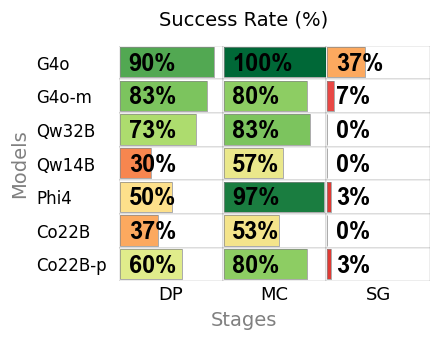

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# 1. Inspect your data keys to ensure they match model_mapping
# Uncomment the following lines to debug if rows appear empty:
# print("Available keys in dictionary:", list(success_rate_dict.keys())[:5])
# print("Expected keys:", list(model_mapping.keys()))

# Model name mapping
model_mapping = {
 
     'q32-ab1': 'Qw32B-ab1',  
     'q32-ab2': 'Qw32B-ab2',  
    'phi4-ab1': 'Phi4-ab1',  
    'phi4-ab2': 'Phi4-ab2',  
}

# Convert dictionary to DataFrame and pivot
# We use .get(model, model) so if a name isn't in the mapping, it keeps the original name
df_list = []
for (model, processor), data in success_rate_dict.items():
    # Handle cases where data might be a simple float or a dict
    rate = data['success_rate'] if isinstance(data, dict) and 'success_rate' in data else data
    
    # Ensure rate is 0-100 scale (if it's 0.0-1.0, multiply by 100)
    if rate <= 1.0: 
        rate *= 100
        
    df_list.append({
        'model': model_mapping.get(model, model),
        'processor': processor,
        'success_rate': rate
    })

heatmap_data = pd.DataFrame(df_list).pivot(index='model', columns='processor', values='success_rate')

# Reorder columns and rows
# NOTE: This filters the rows. If your data keys don't match model_mapping values, rows will be dropped.
heatmap_data = heatmap_data.reindex(columns=['dp', 'mc', 'sg'], index=list(model_mapping.values()))

# Create figure
fig, ax = plt.subplots(figsize=(4.5, 3.5))

# Create colormap (Red to Green)
cmap = LinearSegmentedColormap.from_list('custom', 
                                         ['#D73027', '#F65D5F','#F46D43', '#FDAE61', 
                                          '#FEE08B', '#D9EF8B', '#A6D96A', '#68BA59', '#006837'], 
                                         N=256)

ax.set_xlim(0, len(heatmap_data.columns))
ax.set_ylim(0, len(heatmap_data.index))
ax.invert_yaxis()

# Progress bar height ratio
bar_height_ratio = 0.9

# Draw cells with progress bars
for i, model in enumerate(heatmap_data.index):
    for j, processor in enumerate(heatmap_data.columns):
        value = heatmap_data.loc[model, processor]
        
        if pd.notna(value):
            # 1. Background is now WHITE
            # bg_rect = mpatches.Rectangle((j, i), 1, 1, 
            #                             facecolor='white', 
            #                             edgecolor='black', 
            #                             linewidth=0.6)
            
            # Adjust this gap value (e.g., 0.05 for a small gap)
            gap = 0

            # Draw BACKGROUND with gap
            bg_rect = mpatches.Rectangle(
                (j + gap/2, i + gap/2),  # Offset position
                1 - gap,                 # Reduce width
                1 - gap,                 # Reduce height
                facecolor='white', 
                edgecolor='black', 
                linewidth=0.1
            )
            ax.add_patch(bg_rect)
            
            # 2. Bar color is determined by the score (from cmap)
            bar_color = cmap(value / 100)
            
            # Calculate dimensions
            bar_height = bar_height_ratio
            y_offset = (1 - bar_height) / 2-0.01
            # - 0.02
            x_offset = 0.01
            bar_width = value / 100
            
            # 3. Draw the progress bar (Solid color based on score)
            bar_rect = mpatches.Rectangle((j + x_offset, i + y_offset), bar_width, bar_height,
                                         facecolor=bar_color,
                                         edgecolor='none',
                                         linewidth=0)
            ax.add_patch(bar_rect)
            
            # Add neutral grey border
            bar_border = mpatches.Rectangle((j + x_offset, i + y_offset), bar_width, bar_height,
                                           facecolor='none',
                                           edgecolor='#888888',
                                           linewidth=0.5)
            ax.add_patch(bar_border)
            
            # Add text (always black)
            ax.text(j + 0.09 , i + 0.55, f'{value:.0f}%', 
                   ha='left', va='center', 
                   fontsize=17, weight='bold', color='black', fontname='Arial')

# Set ticks and labels
ax.set_xticks([i + 0.5 for i in range(len(heatmap_data.columns))])
ax.set_yticks([i + 0.5 for i in range(len(heatmap_data.index))])
ax.set_xticklabels(heatmap_data.columns.str.upper(), fontsize=13, weight='regular')
ax.set_yticklabels(heatmap_data.index, fontsize=12, ha='left')

# Remove ticks
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='y', pad=60)

# Labels
ax.set_xlabel('Stages', fontsize=14, weight='regular', labelpad=5, color='gray',x=0.4)
ax.set_ylabel('Models', fontsize=14, weight='regular', labelpad=5, color='gray')

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title('Success Rate (%)', fontsize=14, weight='regular', color='black', pad=15,x=0.4)

plt.tight_layout()

 
 
plt.savefig('success_rate_progress_bars2.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Make them cents
g4o['cost'] = {k: v * 100 for k, v in g4o['cost'].items()}
g4o_mini['cost'] = {k: v * 100 for k, v in g4o_mini['cost'].items()}


27.486981052631574


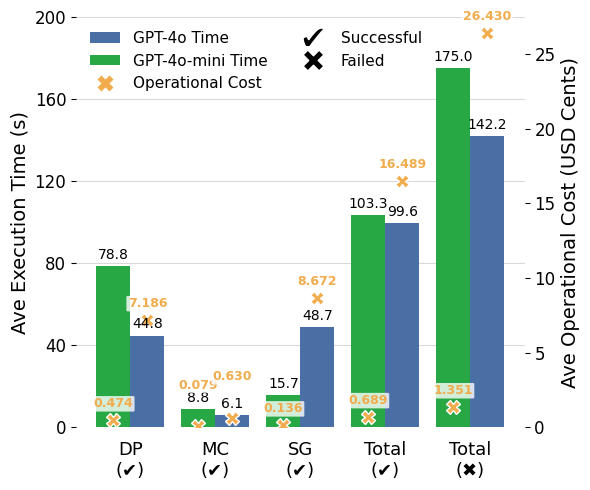

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

# --- 1. Style Configuration ---
COLORS = {
    'primary': '#4a6fa5',       # Muted Blue (GPT-4o Bars)
    'secondary': '#28a745',     # Green (GPT-4o-mini Bars) - NEW
    'accent':  '#f0ac4d',       # Muted Orange (Cost Markers)
    # 'text':    '#333333',       # Dark Grey
    'bg':      '#ffffff',       # Background
    
    'pass':    '#000000',
    'fail':    '#000000',
    'text': '#000000',
 
    'black':   '#000000'
}

# --- 2. Data Preparation ---
keys = ['dp', 'mc', 'sg', 'total', 'total_x']
categories = ['DP\n(✔)', 'MC\n(✔)', 'SG\n(✔)', 'Total\n(✔)', 'Total\n(✖)']

# Data for GPT-4o
times_g4o = np.array([g4o['latency'][k] for k in keys])
costs_g4o = np.array([g4o['cost'][k] for k in keys])

# Data for GPT-4o-mini
times_mini = np.array([g4o_mini['latency'][k] for k in keys])
costs_mini = np.array([g4o_mini['cost'][k] for k in keys])

# --- 3. Setup Figure ---
fig, ax1 = plt.subplots(figsize=(6, 5)) # Slightly wider to fit dual bars
fig.patch.set_facecolor('white')
ax1.set_facecolor(COLORS['bg'])

# Calculate Y-Axis limits based on max of BOTH datasets
max_time = max(times_g4o.max(), times_mini.max())
max_cost = max(costs_g4o.max(), costs_mini.max())
 
y_max_time = np.ceil(max_time / 10) * 10 + 20 # Add buffer
# y_max_cost = np.ceil(max_cost / 0.1) * 0.1 + 0.1
y_max_cost=max_cost*1.04
print(y_max_cost)

# --- 4. Plotting Grouped Bars ---
x = np.arange(len(categories))
width = 0.4 # Width of individual bars

# CHANGE 1: Move Mini to the Left (subtract width/2)
bars2 = ax1.bar(x - width/2, times_mini, width, color=COLORS['secondary'], 
                edgecolor='white', linewidth=0, zorder=3, label='GPT-4o-mini Time')

# CHANGE 2: Move 4o to the Right (add width/2)
bars1 = ax1.bar(x + width/2, times_g4o, width, color=COLORS['primary'], 
                edgecolor='white', linewidth=0, zorder=3, label='GPT-4o Time')


# --- 5. Axis Formatting ---
ax1.set_ylabel('Ave Execution Time (s)', fontsize=14, fontweight='regular', color=COLORS['text'])
ax1.set_ylim(0, y_max_time)
# ax1.set_yticks(np.arange(0, y_max_time + 1, 60)) # Adjusted dynamically usually better, but can keep static
ax1.tick_params(axis='y', labelsize=12, colors=COLORS['text'])
ax1.tick_params(axis='x', length=0, pad=10)

ax1.set_xticks(x)
ax1.set_xticklabels(categories, fontsize=13, fontweight='regular')

# Color logic for labels
for label in ax1.get_xticklabels():
    text = label.get_text()
    if '✖' in text:
        label.set_color(COLORS['fail'])
    elif 'Total' in text:
        label.set_color(COLORS['pass'])
    else:
        label.set_color(COLORS['text'])

ax1.grid(axis='y', linestyle='-', alpha=0.15, color='black', zorder=0)
for spine in ax1.spines.values(): spine.set_visible(False)

ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))
# ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Twin Axis for Cost
ax2 = ax1.twinx()
ax2.set_ylabel('Ave Operational Cost (USD Cents)', fontsize=14, fontweight='regular', color=COLORS['text'])
ax2.set_ylim(0, y_max_cost)
ax2.tick_params(axis='y', labelsize=12, colors=COLORS['text'])
for spine in ax2.spines.values(): spine.set_visible(False)

# --- 6. Markers & Annotations Function (MODIFIED) ---
def plot_markers_and_labels(bars, times, costs, offset_direction):
    """
    Helper to plot markers and labels for a specific set of bars.
    """
    # Calculate Y-position for markers based on ratio
    tri_y_pos = costs / y_max_cost * y_max_time
    ct=0
    lift_more=[2]
    for bar, time, cost, ty in zip(bars, times, costs, tri_y_pos):
        ct+=1
        x_center = bar.get_x() + bar.get_width() / 2
        bar_height = bar.get_height()
        
        # 1. Operational Cost Marker (X)
        ax1.plot(x_center, ty, marker='X', color=COLORS['accent'], markersize=10, 
                 markeredgecolor='white', markeredgewidth=1, zorder=5)

        # 2. Cost Label (Badge) - SMART POSITIONING
        # If the cost marker is very low (like in MC or SG), 
        # we move the label slightly higher than usual to clear the '0.0s' text
        threshold = y_max_time * 0.15 
        if ty < threshold and ct in lift_more:
            # Shift label UP significantly if the marker is at the bottom
            txt_y = ty + (y_max_time * 0.1) 
        else:
            # Standard placement above marker for higher values
            txt_y = ty + (y_max_time * 0.04)
        
        ax1.text(x_center, txt_y, f'{cost:.3f}', ha='center', va='center', 
                 fontsize=9, fontweight='bold', color=COLORS['accent'],
                 bbox=dict(boxstyle='round,pad=0.1', fc='white', ec='none', alpha=0.8), zorder=6)

        # 3. Time Label (Above Bar) - Keep as is per instructions
        ax1.text(x_center, bar_height + (y_max_time * 0.01), f'{time:.1f}', 
                 ha='center', va='bottom', fontsize=10, fontweight='regular', color=COLORS['text'], zorder=5)
# Plot for both sets
plot_markers_and_labels(bars2, times_mini, costs_mini, 1)

plot_markers_and_labels(bars1, times_g4o, costs_g4o, -1)

# --- 7. Legend ---
legend_elements = [
    # Bar Colors
    Rectangle((0,0), 1, 1, facecolor=COLORS['primary'], edgecolor='none', label='GPT-4o Time'),
   
    Rectangle((0,0), 1, 1, facecolor=COLORS['secondary'], edgecolor='none', label='GPT-4o-mini Time'),
  
    
       
    # Cost Marker
    Line2D([0], [0], marker='X', color='w', markerfacecolor=COLORS['accent'], 
           markersize=12, markeredgecolor='none', label='Operational Cost'),
    # Symbols
    Line2D([0], [0], marker='$✔$', color='w', markerfacecolor=COLORS['pass'], 
           markersize=15, label='Successful'),
    Line2D([0], [0], marker='$✖$', color='w', markerfacecolor=COLORS['fail'], 
           markersize=15, label='Failed'),
 
    
]

# Adjust legend columns and position
leg = ax1.legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=False, ncol=2)

plt.tight_layout()
plt.savefig('comparison_chart.pdf', dpi=300, bbox_inches='tight')
plt.show()